In [11]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt 

import cv2 #!pip install opencv-python
import tensorflow as tf                
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.optimizers import SGD, Adam

In [16]:
# 定義子資料夾名稱&對應的數字，檔名不能有中文

class_names = ['cats','dogs']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (64, 64)
#%%
def load_data():
    datasets = ['training_set', 'test_set'] #資料夾
    output = []
    
    # Iterate through training and test sets
    # 训练集和 测试集
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder 
            # (文件夹里的照片反复)
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image 
                # (读取照片的文件夹名字)
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img 
                # (调整照片大小—)
                image = cv2.imread(img_path)
                
                # (cv都照片，颜色默认为BGR， 需要转为RGB，错误表示黑白已转换)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # 添加照片和答案到 List里
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output
#%%
(train_images, train_labels), (test_images, test_labels) = load_data()
#%%

Loading training_set


100%|█████████████████████████████████████████████████████████████████████████████| 4005/4005 [00:05<00:00, 686.40it/s]


Loading test_set


100%|█████████████████████████████████████████████████████████████████████████████| 1012/1012 [00:01<00:00, 714.07it/s]


- 积卷层 : 特征截取
- 池化层 : 特征压缩

In [17]:
#'隨機性'
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

#'標準化'
train_images = train_images / 255.0 
test_images = test_images / 255.0

#'建模'
input_shape = (64, 64, 3) #长64， 宽64， 高3(채닐)

model = Sequential([
    
    #--------------------------------------------------------------------------------------------------
    Conv2D(64, (3, 3),              # 64神经元 （3，3）扫描器的大小
           input_shape=input_shape, # 自变量的 shape
           padding='same',          # 池化层 ： 把通过扫描器扫出来的特征取出来，然后和原图对比 same = 一样大的意思
           activation='relu', 
           strides=2),              # 扫描器的移动间隔
    
    MaxPooling2D(pool_size=(2, 2),  # 压缩大小 2*2
                 strides=2),        # 每隔多少步 做一次压缩
    #--------------------------------------------------------------------------------------------------
    
    Dropout(0.2), #防止过拟合， 随机丢掉一部分的资料
    
    #--------------------------------------------------------------------------------------------------
    Conv2D(128, (3, 3), input_shape=input_shape, 
           padding='same', 
           activation='relu', 
           strides=2),
    
    MaxPooling2D(pool_size=(2, 2), strides=2),
    #--------------------------------------------------------------------------------------------------

    Dropout(0.2),
    
    Flatten(), # 图片摊平 **
    
    Dropout(0.5),
    
    Dense(2, activation='softmax') # 輸出層，分類用softmax
])

model.compile(optimizer = 'adam', # SGD(lr=0.1)
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
history = model.fit(train_images, train_labels, 
                    #validation_data=(test_images, test_labels),
                    #verbose=2,callbacks=[earlyStop],
                    batch_size=256, epochs=45)

Epoch 1/45
32/32 [==============================] - 3s 92ms/step - loss: 0.1409 - accuracy: 0.9482
Epoch 2/45
32/32 [==============================] - 3s 92ms/step - loss: 0.1342 - accuracy: 0.9470
Epoch 3/45
32/32 [==============================] - 3s 92ms/step - loss: 0.1447 - accuracy: 0.9439
Epoch 4/45
32/32 [==============================] - 3s 92ms/step - loss: 0.1354 - accuracy: 0.9478
Epoch 5/45
32/32 [==============================] - 3s 93ms/step - loss: 0.1369 - accuracy: 0.9464
Epoch 6/45
32/32 [==============================] - 3s 93ms/step - loss: 0.1373 - accuracy: 0.9424
Epoch 7/45
32/32 [==============================] - 3s 93ms/step - loss: 0.1419 - accuracy: 0.9439
Epoch 8/45
32/32 [==============================] - 3s 92ms/step - loss: 0.1379 - accuracy: 0.9480
Epoch 9/45
32/32 [==============================] - 3s 92ms/step - loss: 0.1312 - accuracy: 0.9488
Epoch 10/45
32/32 [==============================] - 3s 92ms/step - loss: 0.1372 - accuracy: 0.9468
Epoch 11/

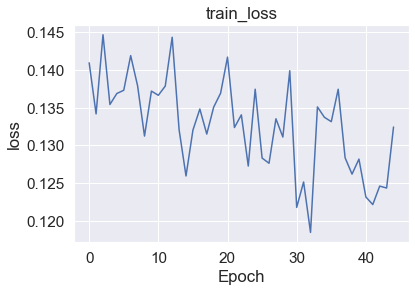

In [33]:
#'模型概況'
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])
#scores = model.evaluate(test_images, test_labels)  
#print('test:',result[1])

In [34]:
#'預測'
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

64/64 [==============================] - 0s 5ms/step


In [35]:
#'混淆矩陣'
CM = confusion_matrix(test_labels, pred_labels)
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 
print(accuracy(CM))

0.8235294117647058


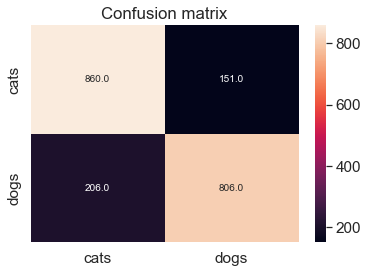

In [51]:
#'混淆矩陣視覺化，看錯誤'
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax, fmt='.1f')
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
#'存模型&讀模型'
from keras.models import load_model
model.save("85%_model")
model = load_model('CNN_model')